In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint
import random

In [2]:
# Read the historical match data
df=pd.read_csv('../data/results.csv')
df=df.sort_index()
df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False


In [4]:
# Extract the match data that we want
fix = df[['date', 'home_team', 'away_team', 'home_score', 'away_score']]
fix.head()

,date,home_team,away_team,home_score,away_score
0,1872-11-30,Scotland,England,0.0,0.0
1,1873-03-08,England,Scotland,4.0,2.0
2,1874-03-07,Scotland,England,2.0,1.0
3,1875-03-06,England,Scotland,2.0,2.0
4,1876-03-04,Scotland,England,3.0,0.0


In [5]:
# A simplified version of the FIFA world ranking model:
# https://digitalhub.fifa.com/m/f99da4f73212220/original/edbm045h0udbwkqew35a-pdf.pdf

# Predicts the expected result: P(A) winning
# Based on the elo chess ranking system
def expected(a_rating, b_rating):
    return 1 / (1 + 10 ** ((b_rating - a_rating) / 600))

# Calculate the change in elo comparing the actual result with the expected result
def elo(old, exp_p, score, k=25):
    # FIFA model adjusts k by competition but I'm lazy
    return old + k * (score - exp_p)

In [90]:
# Calculate the elo over time for each team based on the historical match

# initialize ratings to keep track of current values
team_names=list(fix['home_team'].unique())
current_ratings={}
for t in team_names:
    current_ratings[t]=1500

dates=[]
teams=[]
ratings=[]
    
# For each match
for index, row in fix.iterrows():

    # try/except for some sketchy data
    try:
        new_home_rating=[]
        new_away_rating=[]

        # Extract teams and current ELO
        home_team=row['home_team']
        away_team=row['away_team']
        home_current=current_ratings[home_team]
        away_current=current_ratings[away_team]
        
        # if home win:
        if (row['home_score']>row['away_score']):
            home_result=1
            away_result=0
        # if away win
        elif (row['away_score']<row['home_score']):
            home_result=0
            away_result=1    
        # else draw
        else:
            home_result=0.5
            away_result=0.5

        # append date, team and rating home
        dates.append(row['date'])
        teams.append(home_team)
        ratings.append(elo(home_current,expected(home_current,away_current),home_result))
        current_ratings[home_team]=elo(home_current,expected(home_current,away_current),home_result)
        
        # and the same for the away team
        dates.append(row['date'])
        teams.append(away_team)
        ratings.append(elo(away_current,expected(away_current,home_current),away_result))
        current_ratings[away_team]=elo(away_current,expected(away_current,home_current),away_result)

    except Exception as e:
        print(e)


'Asturias'
'Crimea'
'Crimea'
'Crimea'
'Crimea'
'Crimea'
'Two Sicilies'
'Two Sicilies'
'Two Sicilies'
'Two Sicilies'
'Surrey'
'Maule Sur'
'Maule Sur'


In [91]:
elo_df=pd.DataFrame({'date': dates,
                         'team':teams,
                         'rating':ratings
                        })
elo_df.index=pd.to_datetime(elo_df['date'])
elo_df.head()

,date,team,rating
date,,,
1872-11-30,1872-11-30,Scotland,1500.000000
1872-11-30,1872-11-30,England,1500.000000
1873-03-08,1873-03-08,England,1512.500000
1873-03-08,1873-03-08,Scotland,1487.500000
1874-03-07,1874-03-07,Scotland,1500.599172


In [92]:
elo_df['team'] = elo_df['team'].replace(['United States'], 'USA')
elo_df['team'] = elo_df['team'].replace(['South Korea'], 'Korea Republic')


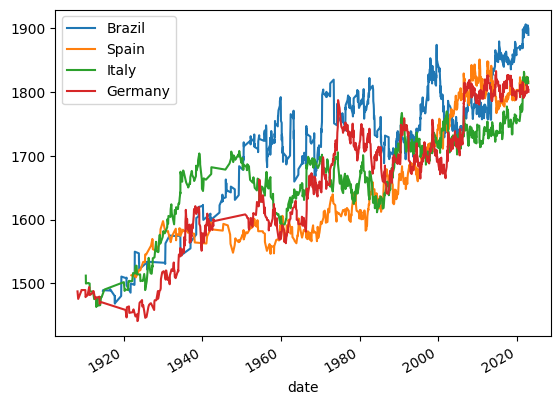

In [93]:
# Visualise a few teams
elo_df[elo_df['team']=='Brazil']['rating'].plot(label='Brazil')
elo_df[elo_df['team']=='Spain']['rating'].plot(label='Spain')
elo_df[elo_df['team']=='Italy']['rating'].plot(label='Italy')
elo_df[elo_df['team']=='Germany']['rating'].plot(label='Germany')
plt.legend()

In [94]:
# Lets say we're only interest in the last 4 years of data (inc the last world cup)
elo_recent=elo_df.loc['01-01-2018':]


In [95]:
# Get the world cup fixtures
world_cup_schedule=pd.read_csv('../data/fifa-world-cup-2022-UTC.csv')
world_cup_schedule.head()

,Match Number,Round Number,Date,Location,Home Team,Away Team,Group,Result
0,1,1,20/11/2022 16:00,Al Bayt Stadium,Qatar,Ecuador,Group A,NaN
1,3,1,21/11/2022 13:00,Khalifa International Stadium,England,Iran,Group B,NaN
2,2,1,21/11/2022 16:00,Al Thumama Stadium,Senegal,Netherlands,Group A,NaN
3,4,1,21/11/2022 19:00,Ahmad Bin Ali Stadium,USA,Wales,Group B,NaN
4,8,1,22/11/2022 10:00,Lusail Stadium,Argentina,Saudi Arabia,Group C,NaN


In [96]:
# Extract the teams 
teams=pd.unique(world_cup_schedule[['Home Team','Away Team']].values.ravel()).tolist()

# remove TBC match data
drop_list=['1A', '2B', '1C', '2D', '1D', '2C',
       '1B', '2A', '1E', '2F', '1G', '2H', '1F', '2E', '1H', '2G',
       'To be announced']

teams=list(set(teams) - set(drop_list))

In [98]:
elo_wc_teams=elo_recent[elo_recent['team'].isin(teams)]['team'].unique()

In [102]:
elo_wc_teams

array(['Denmark', 'Morocco', 'Cameroon', 'Korea Republic', 'USA',
       'Mexico', 'Saudi Arabia', 'Iran', 'Qatar', 'Wales', 'France',
       'Germany', 'Spain', 'Switzerland', 'Argentina', 'Japan',
       'Netherlands', 'England', 'Australia', 'Croatia', 'Poland',
       'Portugal', 'Brazil', 'Costa Rica', 'Senegal', 'Serbia', 'Tunisia',
       'Uruguay', 'Canada', 'Belgium', 'Ghana', 'Ecuador'], dtype=object)

In [109]:
elo_recent[elo_recent['team']=='Denmark']['rating'].std()

27.139765780414436

In [155]:
def model_game(team_a, team_b, SIM_NO=10000, plot=False):

    team_a_sim_elos=[]
    team_b_sim_elos=[]

    team_a_elo=elo_recent[elo_recent['team']==team_a]['rating'].iloc[-1]
    team_a_elo_std=elo_recent[elo_recent['team']==team_a]['rating'].std()

    team_b_elo=elo_recent[elo_recent['team']==team_b]['rating'].iloc[-1]
    team_b_elo_stdev=elo_recent[elo_recent['team']==team_b]['rating'].std()

    print('Modelling: '+team_a+' ('+str(int(team_a_elo))+') vs '+team_b+' ('+str(int(team_b_elo))+')')

    for i in range(0,SIM_NO):
        team_a_sim_elos.append(random.gauss(team_a_elo, team_a_elo_std))
        team_b_sim_elos.append(random.gauss(team_b_elo, team_b_elo_stdev))

    team_a_results=[]
    team_b_results=[]
    for i in range(0,SIM_NO):
        result=expected(team_a_sim_elos[i], team_b_sim_elos[i])
        team_a_results.append(result)
        team_b_results.append(1-result)

    # # Change of Team A winning
    # p_a_win=np.round(100*((np.array(team_a_results)>0.62).sum()/SIM_NO),2)

    # # Change of Team A Drawing
    # p_draw=np.round(100*(((np.array(team_a_results)>0.38) & (np.array(team_a_results)<0.62)).sum()/SIM_NO),2)

    # # Change of Team A Losing
    # p_b_win=np.round(100*((np.array(team_a_results)<0.38).sum()/SIM_NO),2)

    p_a_win=np.round(np.array(team_a_results).sum()/SIM_NO,2)
    p_b_win=np.round(1-p_a_win,2)

    result=None
    if p_a_win>0.55:
        result=team_a+' WIN!'
    elif p_a_win<0.45:
        result=team_b+' WIN!'
    else:
        result='DRAW!'
    
    if plot:
        plt.figure(figsize=(10,5))
        plt.hist(team_a_results,alpha=0.5,bins=20,label=team_a)
        plt.hist(team_b_results,alpha=0.5,bins=20,label=team_b)
        plt.legend()
        plt.axvline(x=0.5,ls='--',c='k',alpha=0.5)
        plt.axvline(x=0.38,ls='--',c='r',alpha=0.5)
        plt.axvline(x=0.62,ls='--',c='r',alpha=0.5)

        plt.text(x=0.44,y=100,s='Draw  zone',c='r')

    

    return p_a_win, p_b_win, result

Modelling: Senegal (1701) vs Netherlands (1819)


(0.39, 0.61, 'Netherlands WIN!')

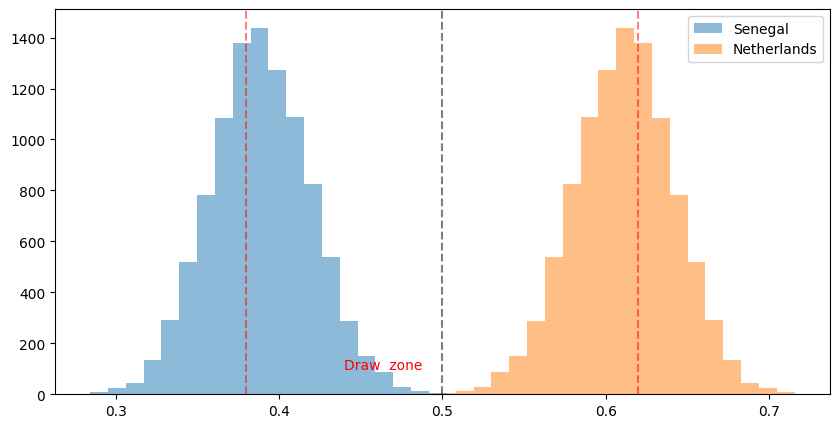

In [157]:
model_game('Senegal','Netherlands',plot=True)

